In [ ]:
#pip install pandas numpy jupyter openai python-dotenv datasets seaborn matplotlib scikit-learn
import os
import json
from openai import OpenAI
import pandas as pd
from jinja2 import Environment, FileSystemLoader, select_autoescape
from dotenv import load_dotenv
load_dotenv()
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
#pip install pandas numpy jupyter openai python-dotenv datasets seaborn matplotlib scikit-learn
import os
import json
from openai import OpenAI
import pandas as pd
from jinja2 import Environment, FileSystemLoader, select_autoescape
from dotenv import load_dotenv
load_dotenv()
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set OpenAI API key
OpenAI.api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=OpenAI.api_key)

# Load Jinja2 template
env = Environment(
    loader=FileSystemLoader("."),
    autoescape=select_autoescape()
)
template = env.get_template("groundedness_guardrail.j2")

# Function to process a single row
def evaluate_row(row, model="gpt-4"):
    prompt = template.render({
        "user_query": row["query"],
        "retrieved_context": row["context"],
        "model_answer": row["answer"]
    })

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        raw_output = response.choices[0].message.content.strip()
        parsed = json.loads(raw_output) if raw_output.startswith("{") else {"REASONING": [raw_output], "SCORE": "FAIL"}
    except Exception as e:
        parsed = {"REASONING": [f"Error: {str(e)}"], "SCORE": "FAIL"}

    return pd.Series({
        "score": parsed.get("SCORE", "FAIL"),
        "reasoning": " | ".join(parsed.get("REASONING", ["Missing reasoning"]))
    })

# Vectorized batch evaluation function
def evaluate_groundedness_batch(df: pd.DataFrame, output_csv="groundedness_results.csv") -> pd.DataFrame:
    results = df.apply(evaluate_row, axis=1)
    full_df = pd.concat([df, results], axis=1)
    full_df.to_csv(output_csv, index=False)
    print(f"✅ Results saved to {output_csv}")
    return full_df


In [16]:
data= pd.read_csv("halueval_50x2_groundedness.csv")

evaluate_groundedness_batch(data)

 


✅ Results saved to groundedness_results.csv


,query,context,answer,label,score,reasoning
0,The manager in which Mark Lazarus clashed with...,He transferred to Wolverhampton Wanderers for...,1948 and 1964,1,PASS,The document states that Stan Cullis was the m...
1,The manager in which Mark Lazarus clashed with...,He transferred to Wolverhampton Wanderers for...,Mark Lazarus clashed with the manager of Wolve...,0,FAIL,The document does not provide specific years d...
2,"No. 11 Squadron RAAF was based at what base, 2...",No. 11 Squadron is a Royal Australian Air Forc...,RAAF Base Edinburgh,1,PASS,The document states that No. 11 Squadron is ba...
3,"No. 11 Squadron RAAF was based at what base, 2...",No. 11 Squadron is a Royal Australian Air Forc...,"RAAF Base Edinburgh, located in Australia.",0,PASS,The answer correctly identifies RAAF Base Edin...
4,Which movie starring Kim Roi-ha is based on Ko...,"Kim Roi-ha (born November 15, 1965) is a South...",Memories of Murder,1,PASS,The document mentions that Kim Roi-ha played a...
...,...,...,...,...,...,...
95,Where is the broadcast studio of the channel t...,The murderer of Neda is disputed; according t...,"CNN, BBC, and Fox News do not have a common st...",0,FAIL,The document does not provide any information ...
96,Which The 'Burbs actor was also a writer and a...,The 'Burbs is a 1989 American comedy thriller ...,Rick Ducommun,1,PASS,The document mentions that Rick Ducommun was a...
97,Which The 'Burbs actor was also a writer and a...,The 'Burbs is a 1989 American comedy thriller ...,Carrie Fisher was also a comedian.,0,FAIL,The document mentions that Richard 'Rick' Duco...
98,Who drafted the compromise which followed the ...,"The Public Land Commission, a former agency of...",Henry Clay,1,PASS,The document clearly states that the compromis...


✅ Accuracy: 84.00%

📊 Classification Report:

                precision    recall  f1-score   support

Ungrounded (0)       0.93      0.74      0.82        50
  Grounded (1)       0.78      0.94      0.85        50

      accuracy                           0.84       100
     macro avg       0.85      0.84      0.84       100
  weighted avg       0.85      0.84      0.84       100

🧮 Confusion Matrix (raw counts):

                Ungrounded (0)  Grounded (1)
Ungrounded (0)              37            13
Grounded (1)                 3            47


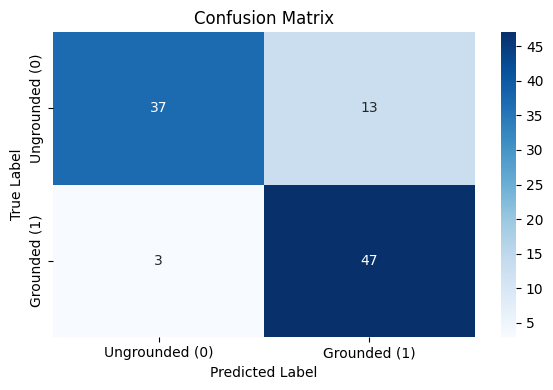

In [ ]:


results= pd.read_csv("groundedness_results.csv")

df = pd.DataFrame(results)

# Step 2: Convert 'PASS' to 1, 'FAIL' to 0
df["predicted"] = df["score"].map({"PASS": 1, "FAIL": 0})

# Step 3: Evaluate
accuracy = accuracy_score(df["label"], df["predicted"])
report = classification_report(df["label"], df["predicted"], target_names=["Ungrounded (0)", "Grounded (1)"])

# Step 4: Print results
print(f"✅ Accuracy: {accuracy:.2%}\n")
print("📊 Classification Report:\n")
print(report)

# Step 5: Confusion Matrix
cm = confusion_matrix(df["label"], df["predicted"])
labels = ["Ungrounded (0)", "Grounded (1)"]

# Print matrix
print("🧮 Confusion Matrix (raw counts):\n")
print(pd.DataFrame(cm, index=labels, columns=labels))

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()





In [ ]:

# Step 3: Convert to pandas and sample 100
df = pd.DataFrame(dataset)
sampled_df = df.sample(n=100, random_state=42).reset_index(drop=True)

# Step 4: Rename to match evaluator format
sampled_df = sampled_df.rename(columns={
    "question": "query",
    "evidence": "context",
    "response": "answer"
})
sampled_df = sampled_df[["query", "context", "answer"]]

# Step 5: Save to CSV
sampled_df.to_csv("halueval_sample_100.csv", index=False)

print("✅ Saved 100 sampled examples to 'halueval_sample_100.csv'")